# Comparing ANHA4 d18O with Obs

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
#sys.setdefaultencoding('utf8')
sys.path.insert(0, '_libs/')

In [3]:
import glob
#import pyproj
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, cm
% matplotlib inline

In [4]:
from NEMO_tools import int_profile, bin_profile, find_inland, reporj_NEMOgrid

# Get the data ready

In [5]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/BGEP_d18O.mat')
x03 = MAT['d18O2003'][:, 1]; y03 = MAT['d18O2003'][:, 0]; z03 = MAT['d18O2003'][:, 2]; d18O03 = MAT['d18O2003'][:, 3]
x04 = MAT['d18O2004'][:, 1]; y04 = MAT['d18O2004'][:, 0]; z04 = MAT['d18O2004'][:, 2]; d18O04 = MAT['d18O2004'][:, 3]
x04[d18O04<0]=np.nan; y04[d18O04<0]=np.nan; z04[d18O04<0]=np.nan; d18O04[d18O04<0]=np.nan
x05 = MAT['d18O2005'][:, 1]; y05 = MAT['d18O2005'][:, 0]; z05 = MAT['d18O2005'][:, 2]; d18O05 = MAT['d18O2005'][:, 3]

In [6]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/HLY_d18O.mat')
xH = np.squeeze(MAT['lon'][:]); yH = np.squeeze(MAT['lat'][:]); zH = np.squeeze(MAT['dep'][:]); d18OH = np.squeeze(MAT['d18O'][:])

In [7]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/CBL_d18O.mat')
xC = np.squeeze(MAT['lon'][:]); yC = np.squeeze(MAT['lat'][:]); zC = np.squeeze(MAT['dep'][:]); d18OC = np.squeeze(MAT['d18O'][:])

In [8]:
x_all = np.hstack((x03, x04, x05, xH, xC))
y_all = np.hstack((y03, y04, y05, yH, yC))
z_all = np.hstack((z03, z04, z05, zH, zC))
d18O_all = np.hstack((d18O03, d18O04, d18O05, d18OH, d18OC))

In [13]:
xC.shape

(971,)

In [14]:
year = np.array([200308, 200408, 200508, 200308, 200209])
time_ind = np.array([8, 19, 31, 42])
proxy_d18O = [1, 2, 3, 1, 0]
time_limit = np.array([223, 223+397, 223+397+302, 223+397+302+566, 223+397+302+566+971])-1

# Get the model output ready

In [15]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/SPIN06_SET02_1m_20020101_20131231_ptrc_T.nc'

In [16]:
ptrc_obj = nc.Dataset(FName)
Ba = np.squeeze(ptrc_obj.variables['Ba'][time_ind, :, :, :]) #67
d18O = np.squeeze(ptrc_obj.variables['d18O'][time_ind, :, :, :])
d18O[Ba==0]=np.nan
nav_lat = ptrc_obj.variables['nav_lat'][:]
nav_lon = ptrc_obj.variables['nav_lon'][:]
deptht = ptrc_obj.variables['deptht'][:]

In [17]:
x = x05[z05<900]
y = y05[z05<900]
d18O_sample = d18O05[z05<900]
d = z05[z05<900]

In [18]:
locx, locy = Nts.nearest_search(nav_lon, nav_lat, x, y)

#Comparisons

In [19]:
def unique_continue(x):
    # Has the functionality of numpy.unique but work with "repeated and continued" elements    
    A = np.diff(x)
    head = [0]
    counts = []
    sub_counts = 1
    for i in range(len(A)):
        if A[i] == 0:
            sub_counts += 1
        else:
            counts.insert(len(counts), sub_counts)            
            sub_counts = 1
            head.insert(len(counts), i)
        # deal with the end of an array
        if i == len(A)-1:
            counts.insert(len(counts), sub_counts)            
            sub_counts = 1
            head.insert(len(counts), i)
    return np.array(head), np.array(counts)

In [20]:
head_loc, counts_loc = unique_continue(locx*locy)
head_loc[1:]=head_loc[1:]+1

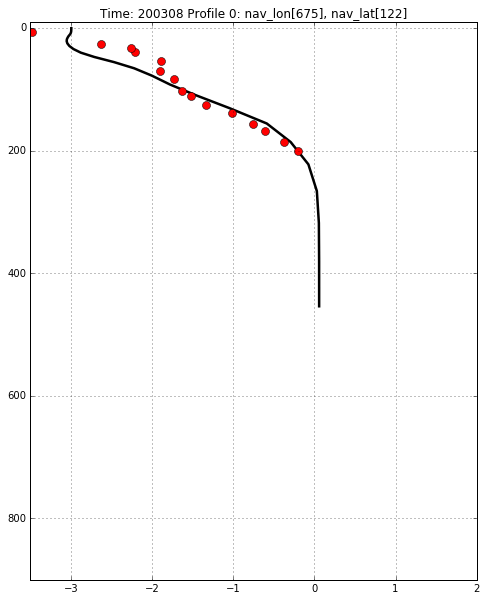

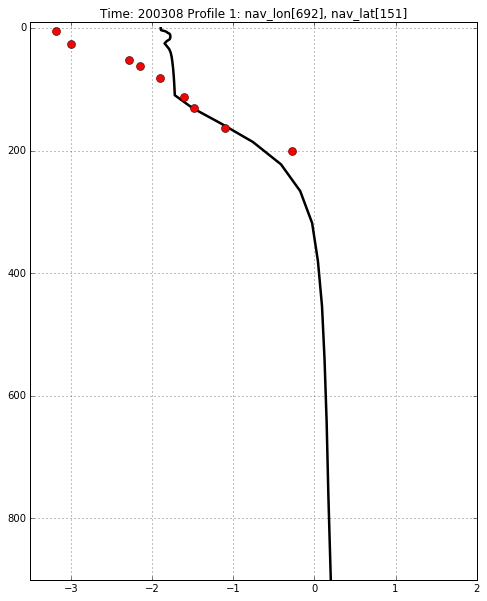

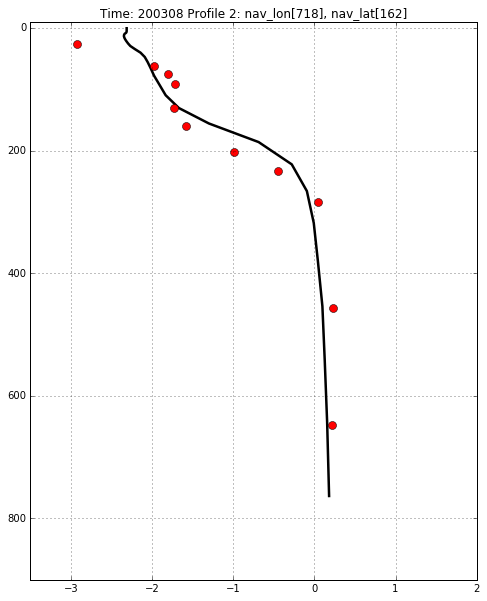

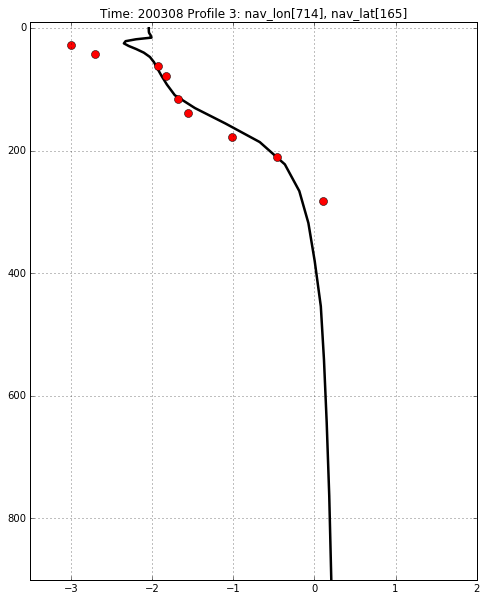

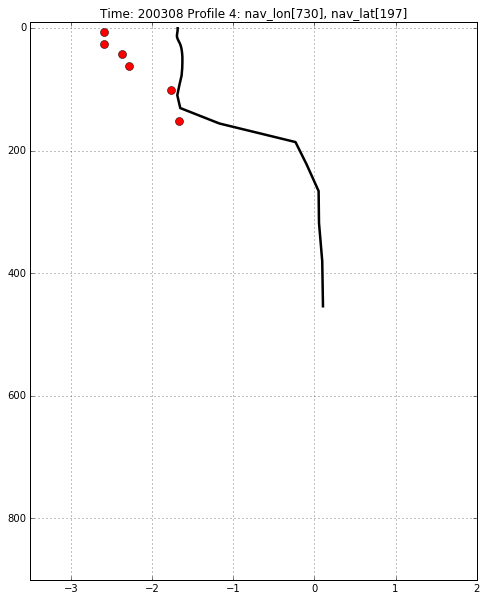

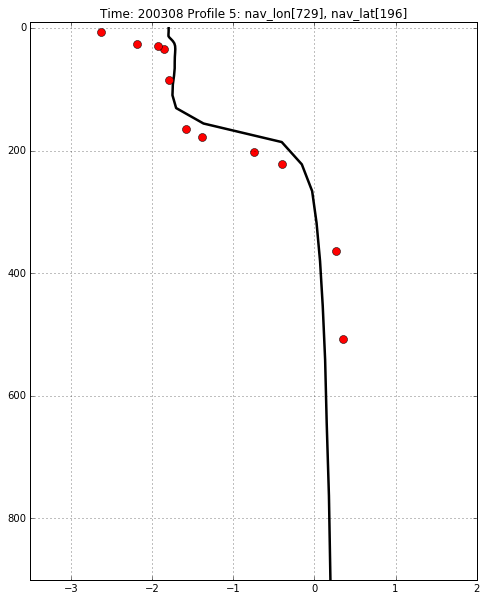

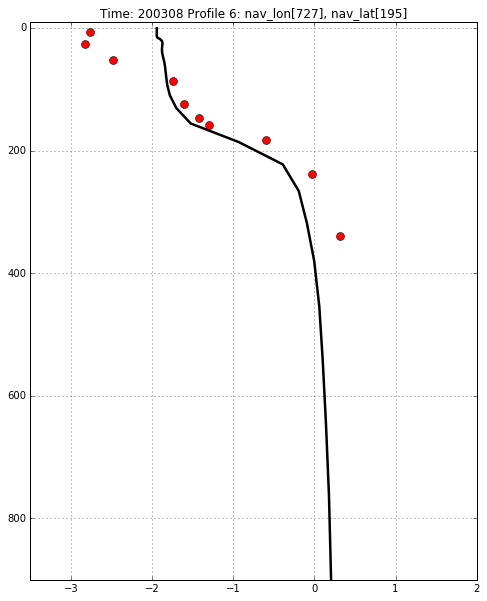

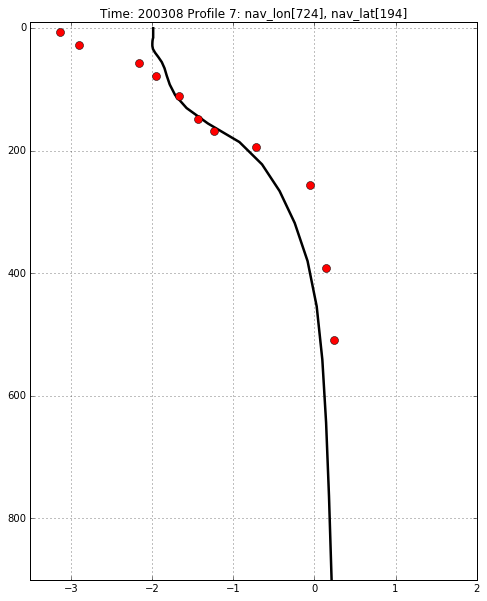

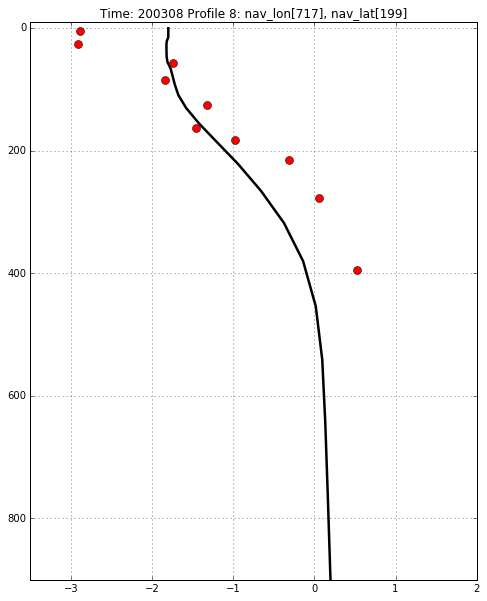

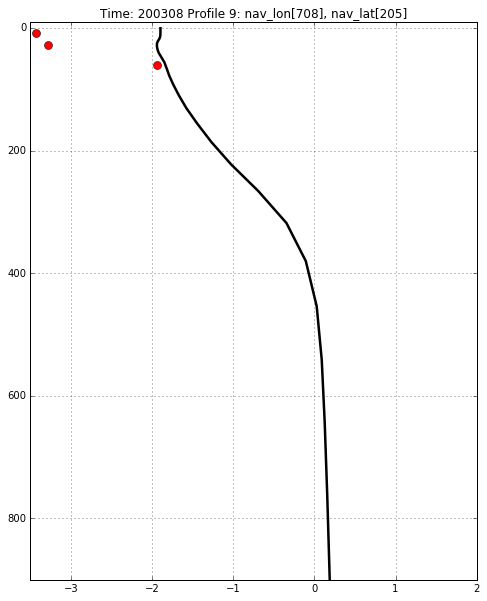

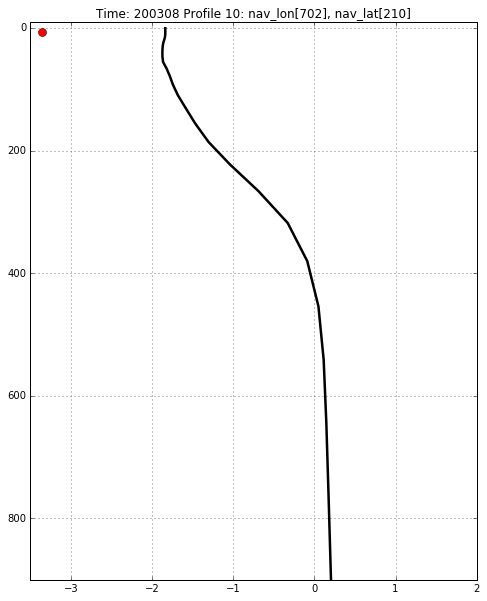

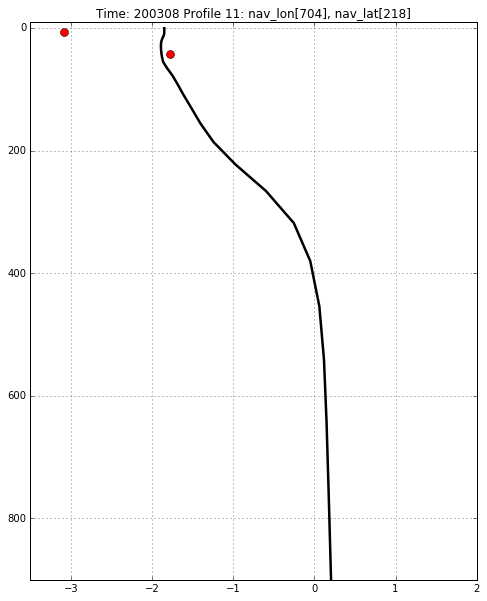

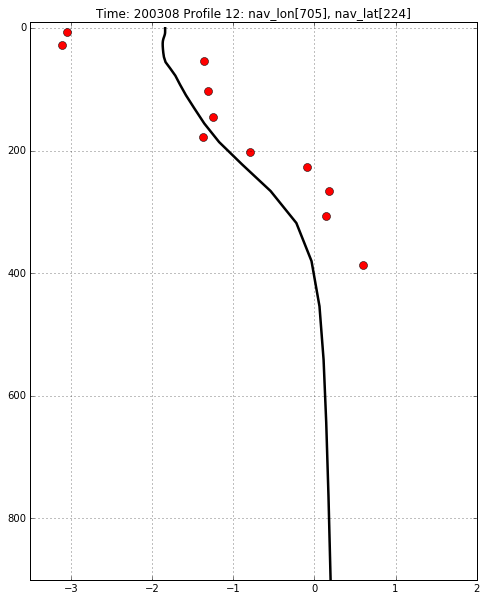

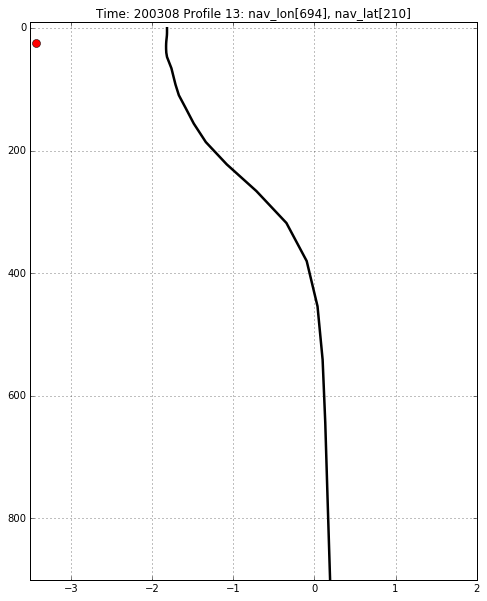

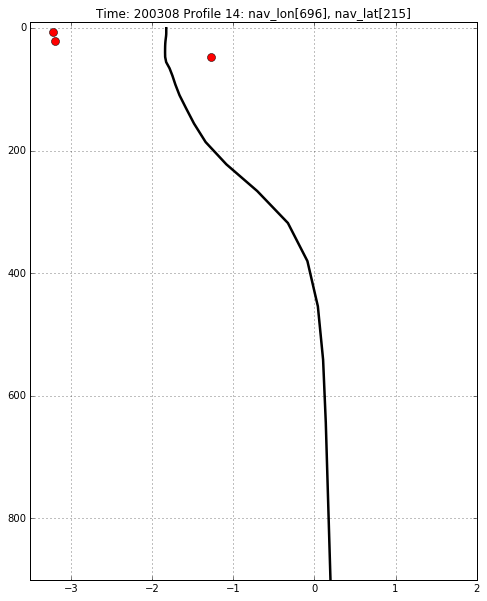

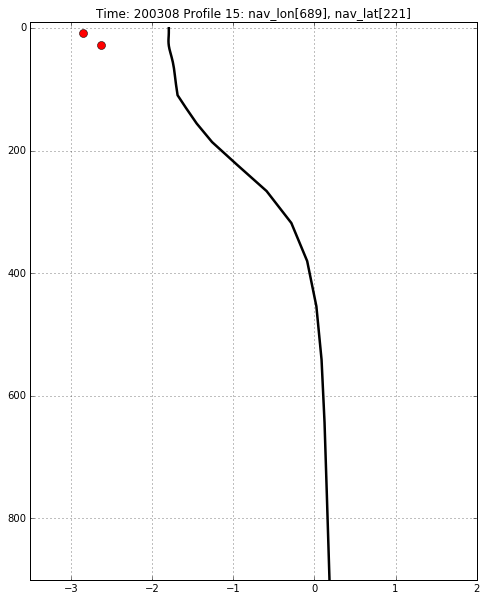

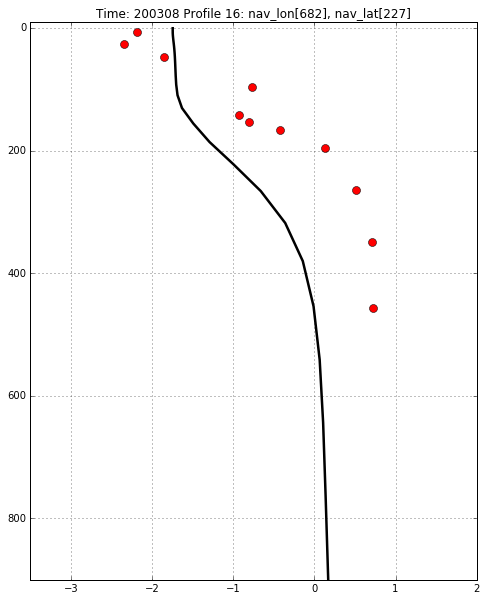

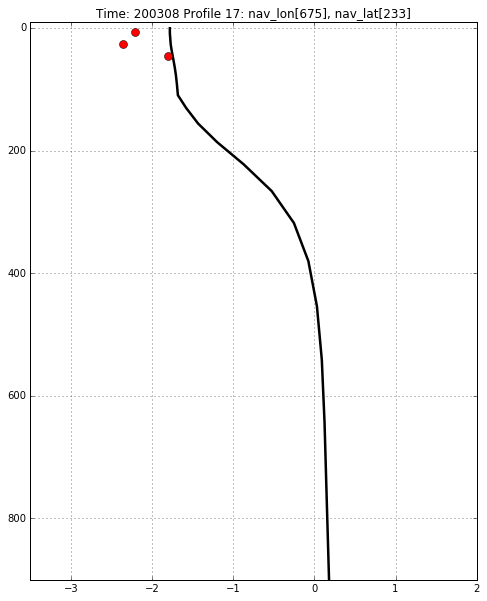

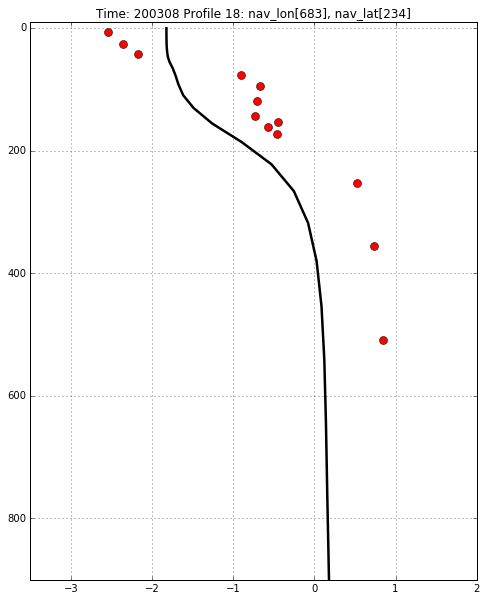

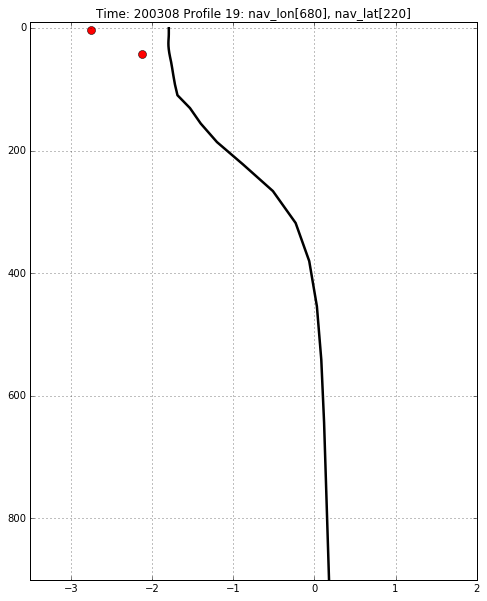

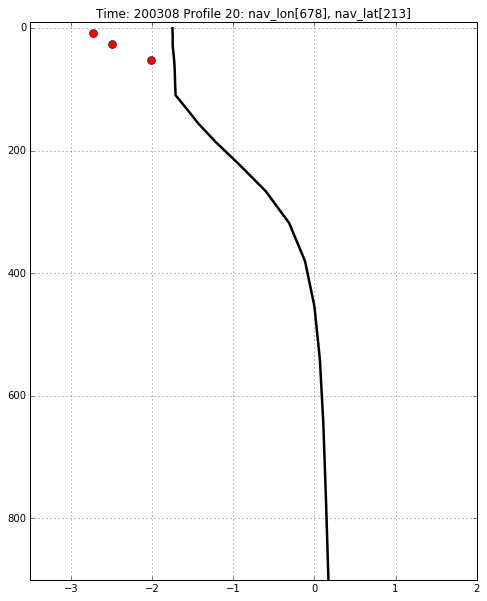

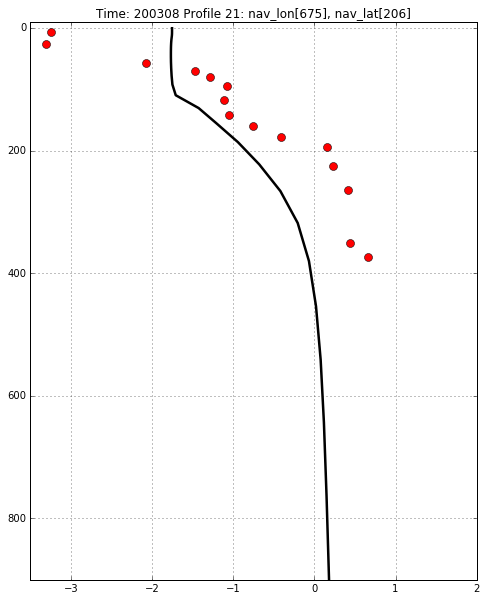

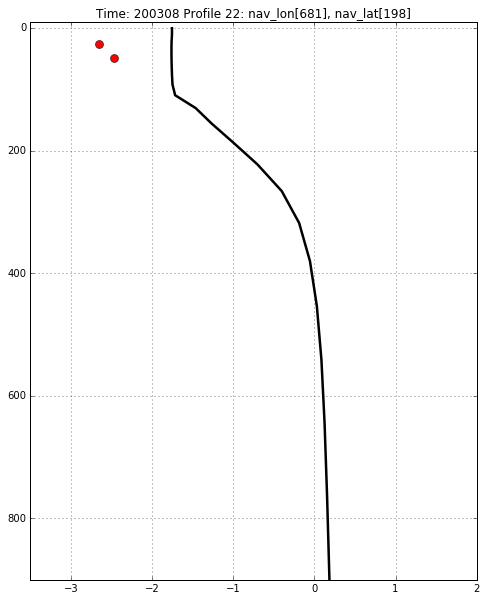

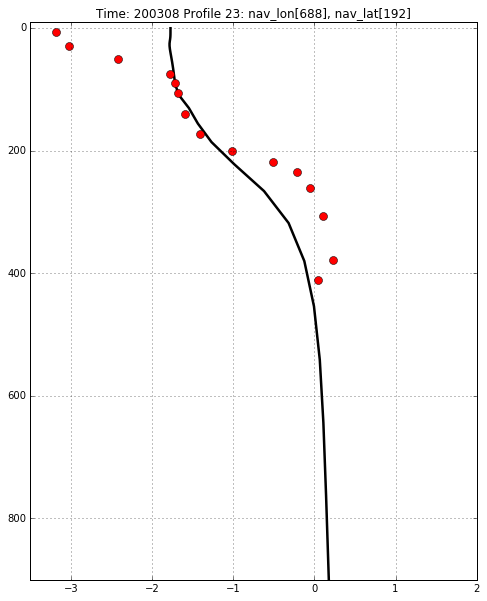

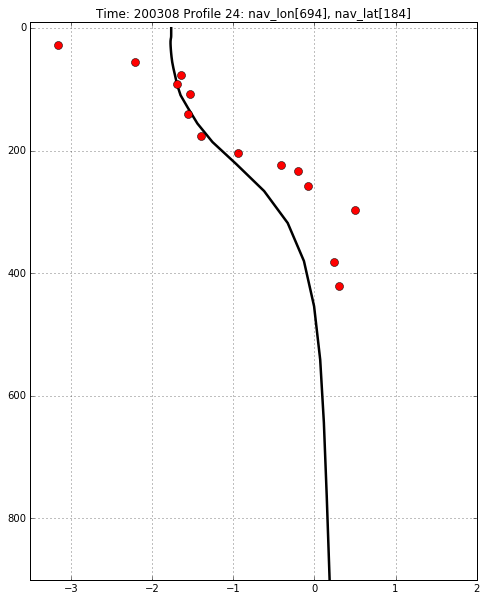

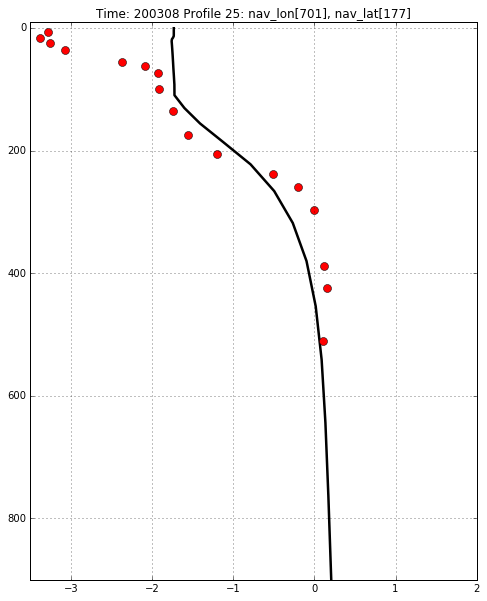

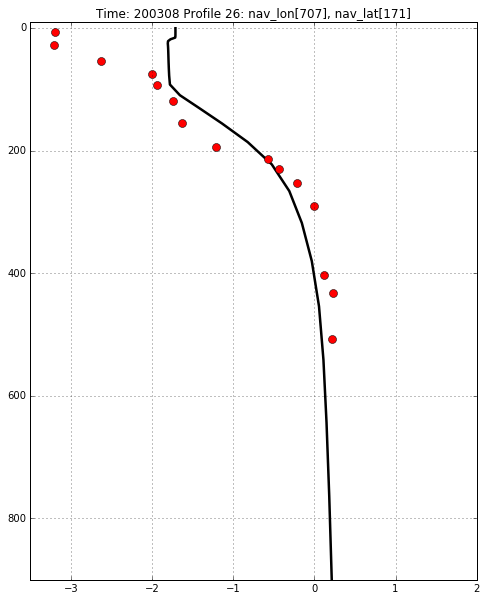

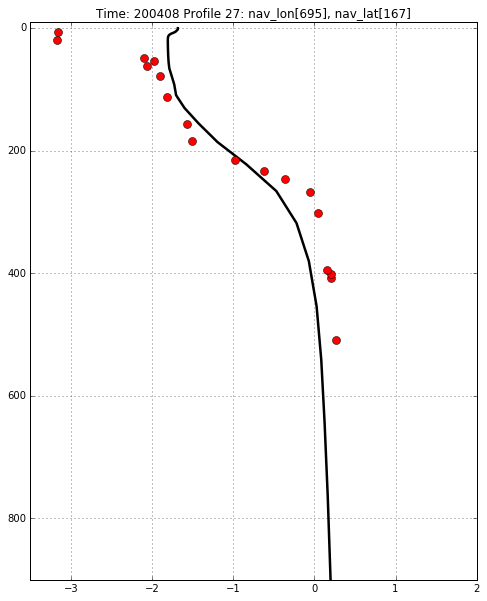

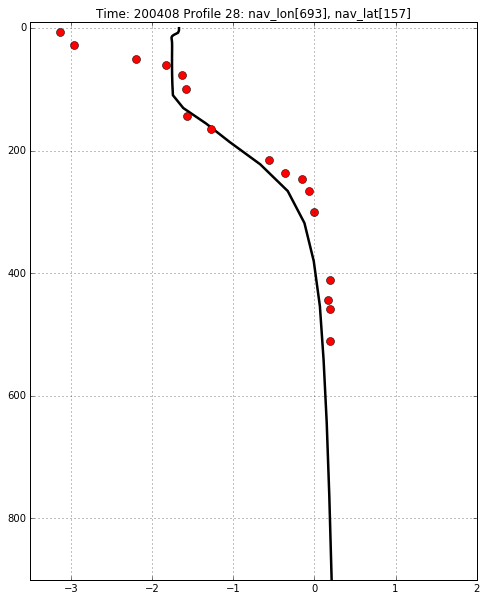

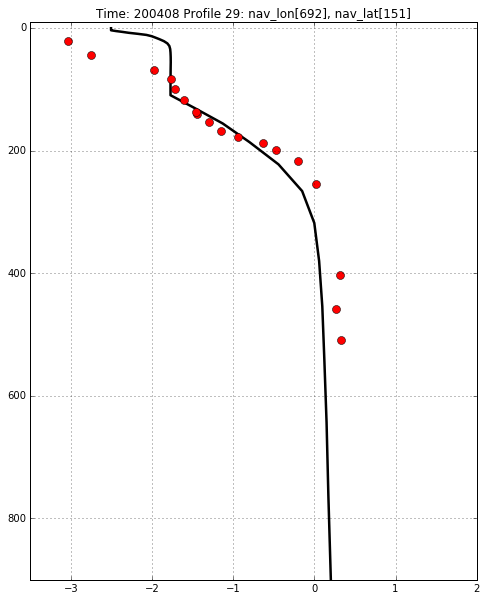

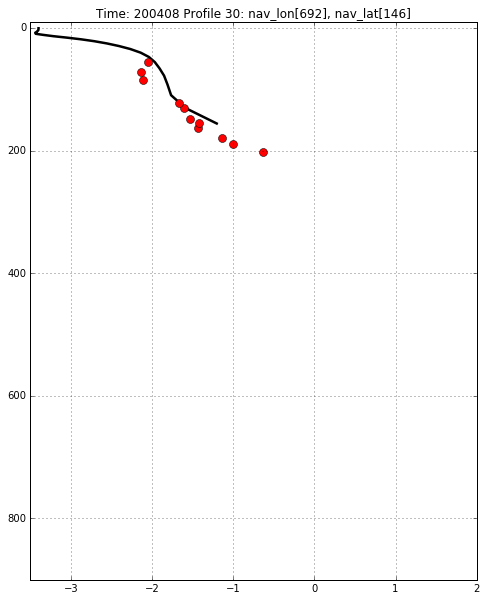

In [22]:
for i in range(len(head_loc)-1):
    
    t_loc = np.searchsorted(time_limit, head_loc[i])
    d18O_t = d18O[proxy_d18O[t_loc], :, :, :]
    
    fig = plt.figure(figsize=(8, 10))
    ax = fig.gca(); ax.grid()
    ax.set_ylim(-10, 900); ax.invert_yaxis()
    ax.plot(d18O_t[:, locx[head_loc[i]], locy[head_loc[i]]], deptht, 'k-', lw=2.5)

    ax.plot(d18O_sample[head_loc[i]:(head_loc[i]+counts_loc[i])], d[head_loc[i]:(head_loc[i]+counts_loc[i])], 'ro', ms=8)
    ax.set_title('Time: {} Profile {}: nav_lon[{}], nav_lat[{}]'.format(year[t_loc], i, locx[head_loc[i]], locy[head_loc[i]]))
    ax.set_xlim([-3.5, 2])

In [25]:
lev2 = np.array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])

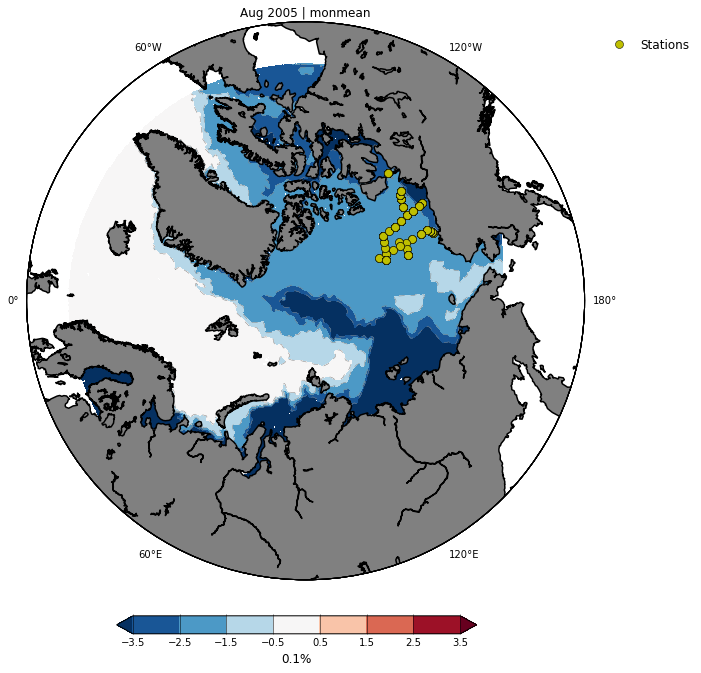

In [28]:
fig=plt.figure(figsize=(10, 10));
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y=proj(nav_lon, nav_lat)
CS=proj.contourf(x, y, d18O[-1, 0, :, :], lev2, cmap=plt.cm.RdBu_r, extend='both')
proj.contour(x, y, d18O[-1, 0, :, :], lev2, linewidths=0.5, colors=('gray',))

proj.plot(x[locx, locy], y[locx, locy], 'yo', ms=8, label='Stations')

LG=ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=1, numpoints=1); LG.draw_frame(False)

cax = fig.add_axes([0.25, 0.05, 0.5, 0.025])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('0.1%', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(lev2)

ax.set_title('Aug 2005 | monmean', fontsize=12)
